# Machine Learning - Report 2

The purpose of this report is to train algorithms to perform facial recognition on a given dataset. In contrast to the previous report which utilized supervised learning techniques, this report will have a focus on unsupervized learning as well as some other techniques that can be used to achieve good results with small datasets.

As with the first report, the `seaborn` library will be used for plotting and `scikit-learn-intelex` will be used to optimize `scikit-learn` to run on Intel architecture.

In [33]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(); sns.set_palette('deep'); sns.set_palette([sns.color_palette()[i] for i in [0,2,3,4,7,9]])
plt.rc('legend', fontsize=10);

from sklearnex import patch_sklearn
patch_sklearn()

import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Preliminary Evaluation of the Dataset

We observe that the dataset contains 64x64 pixel pictures of 40 different people, 10 pictures per person. 

The pictures are each labeled with a number corresponding to the person they belong to, note that since we will be performing unsupervised learning, the labels are only for us to qualitatively assess the performance of the trained algorithms, they are not used in the training of the models.

In [34]:
with open('Datasets/faces_dict.p', 'rb') as f:
    data = pkl.load(f)

plt.rcParams["figure.figsize"] = (10*0.8,40*0.8)
fig, axs = plt.subplots(40, 10)
for t in set(data['target']):
    k=0
    for i in data['images'][data['target']==int(t)]:
        axs[t,k].imshow(i, cmap='gray')
        axs[t,k].axis("off")
        axs[t,k].text(0, 64, str(t), fontsize=8, bbox=dict(boxstyle="square,pad=0.1", fc="w", lw=0.1))
        k+=1

The dataset will be partitioned into a training set and a testing set, assigning 40 samples to the testing set. 

The split will be stratified in order to ensure that the testing set will consist of one picture of each target, the remaining N being used for training. 

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40)
train_idx, test_idx = next(strat_split.split(data['data'], data['target']))
X_train = data['data'][train_idx]
y_train = data['target'][train_idx]
X_test = data['data'][test_idx]
y_test = data['target'][test_idx]

X_train = [np.array(x) for x in X_train]
X_test  = [np.array(x) for x in X_test]

## Dimensionality Reduction

In order to facilitate finding meaningful clusters in the dataset and to significantly speed up the training of the algorithms, dimensionality reduction will be used. The reduction will be done with Principal Component Analysis. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print(f"Original dataset: {len(X_train[1])} dimensions\n Reduced dataset: {len(X_train_pca[1])} dimensions")

Original dataset: 4096 dimensions
 Reduced dataset: 64 dimensions


## K-means Clustering

The first unsupervised training algorithm we will observe is K-means clustering. 

In its simplest form, K-means clustering can be trained by reducing the dimensionality of the dataset all the way to 2 dimensions and partitioning the resulting feature space into $K$ regions, with $K$ equal to the number of classes in the dataset, in this case 40.

In [ ]:
from sklearn.cluster import KMeans

pca_2 = PCA(n_components=2)
X_train_pca_2 = pca_2.fit_transform(X_train)
X_test_pca_2  = pca_2.transform(X_test)

kmeans = KMeans(n_clusters=40).fit(X_train_pca_2)

The only advantage of reducing the dimensionality of the problem to two dimenisons is that it makes it possible to visualize the partitioned reduced feature space and develop an intuition on how the algorithm will operate when extended to higher dimensions.

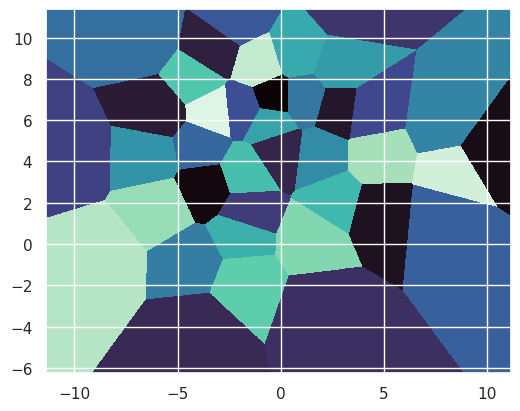

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
h=0.01
x_min, x_max = X_test_pca_2[:,0].min()-1, X_test_pca_2[:,0].max()+1
y_min, y_max = X_test_pca_2[:,1].min()-1, X_test_pca_2[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=sns.color_palette("mako", as_cmap=True))

We can now scatter the testing set onto the partitioned feature space to qualitatively observe the performance of the algorithm.

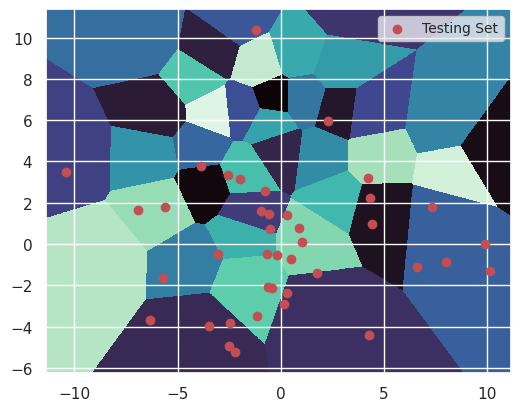

In [ ]:
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=sns.color_palette("mako", as_cmap=True))
plt.scatter(X_test_pca_2[:,0], X_test_pca_2[:,1], color='r', label="Testing Set")
plt.legend()

Needless to say, the performance of the algorithm is terrible when dimensionality is reduced to only two dimensions. Having visualized how the K-means algorithm will operate, we will apply it to a more useful dimensionality.

### Hyperparameter Tuning

There are actually two hyperparameters that we can tune in our problem, one is the number of means $K$ that will be used to partition the feature space, the other is the number of components $N$ that the feature space will be reduced into.

For practicality, we will keep $N$ at 241 components and only tune the $K$ hyperparameter, but it is good to keep in mind that $N$ can also be tuned.

The absolute minimum value that $K$ can take is the number of classes in the dataset, in this case 40, however a higher number is reasonable since the same target can form more than one cluster in the target space (for example, one cluster of pictures looking to the left and another cluster of pictures looking to the right).

The maximum value that $K$ can reasonably take is the number of samples that there are the training, but this would be a case of terrible overfitting. We'll sweep the value of $K$ from the minimum of 40 to a more reasonable maximum of 200.

In [ ]:
from sklearn.cluster import KMeans

k_range = range(40, 202, 2)
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

The silhouette score will be used to determine the best $K$.

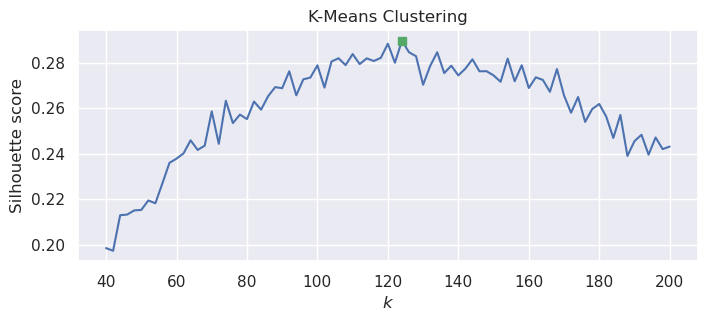

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_) for model in kmeans_per_k]
inertias = [model.inertia_ for model in kmeans_per_k]

def plot_score(ax, k_range, silhouette_scores, title):
    best_index = np.argmax(silhouette_scores)
    best_k = k_range[best_index]
    best_score = silhouette_scores[best_index]
    
    ax.plot(k_range, silhouette_scores)
    ax.set_xlabel("$k$")
    ax.set_ylabel("Silhouette score")
    ax.title.set_text(title)
    ax.plot(best_k, best_score, "s")

plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots(1,1)
plot_score(ax, k_range, silhouette_scores, "K-Means Clustering")

There is some variance regarding the best value for $k$, but it is consistently in the 120 range, 120 is a reasonable number for this dataset, since it means on average 3 clusters for each one of the 40 targets. 

### Testing the trained model

Having chosen the best $K$, we will qualitatively assess the performance of the algorithm by classifying the testing set into the various clusters.

We will plot the individual faces in the testing set on the left hand column, and the cluster it was classified into on the right hand column, each face properly labeled.

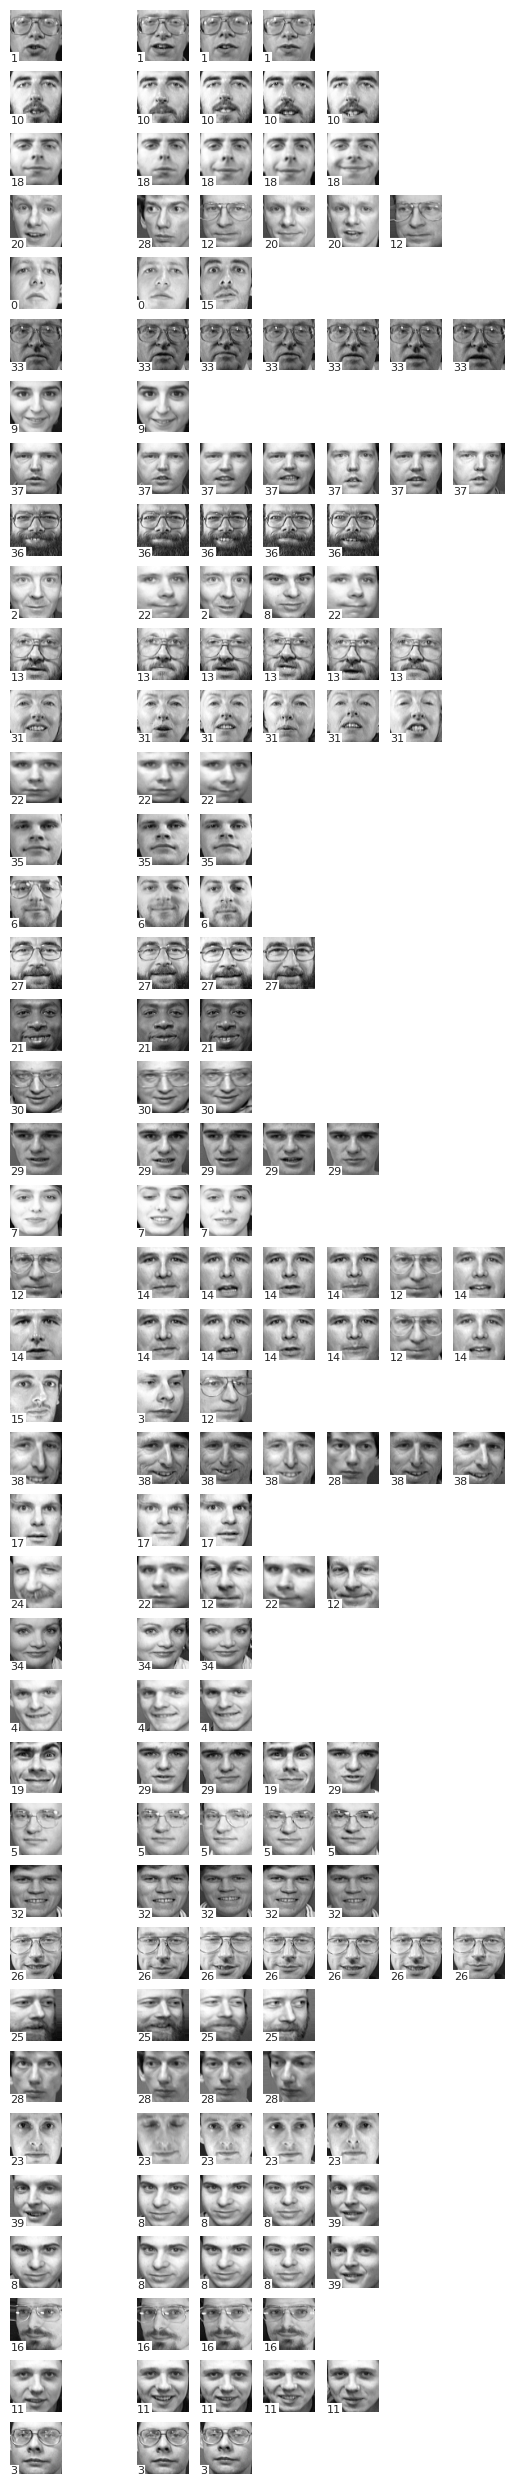

In [ ]:
kmeans = kmeans_per_k[k_range.index(120)]

maxsize = max([sum(kmeans.labels_==c) for c in kmeans.predict(X_test_pca)])
plt.rcParams["figure.figsize"] = (0.8*(maxsize+2),0.8*40)
fig, axs = plt.subplots(40, maxsize+2)
for ax in axs:
    for a in ax:
        a.axis("off")
k=0
for test_face, test_target, cluster_id in zip(X_test, y_test, kmeans.predict(X_test_pca)):
    axs[k,0].imshow(test_face.reshape(64,64), cmap='gray')
    axs[k,0].text(0, 64, str(test_target), fontsize=8, bbox=dict(boxstyle="square,pad=0.1", fc="w", lw=0.1))
    in_cluster = kmeans.labels_==cluster_id 
    i=2
    for face, label in zip(np.array(X_train)[in_cluster], y_train[in_cluster]):
        axs[k,i].imshow(face.reshape(64,64), cmap='gray')
        axs[k,i].text(0, 64, str(label), fontsize=8, bbox=dict(boxstyle="square,pad=0.1", fc="w", lw=0.1))
        i+=1
    k+=1

### Alternatives to K-Means

Scikit-Learn exports several clustering models other than K-Means, which can vary in their parameters, clustering algorithms, and/or metrics used to calculate distance. 

We will compare agglomerative clustering to our K-means results, since the two models use the number of clusters $K$ as their characteristic parameter making it easy to make a direct comparison.

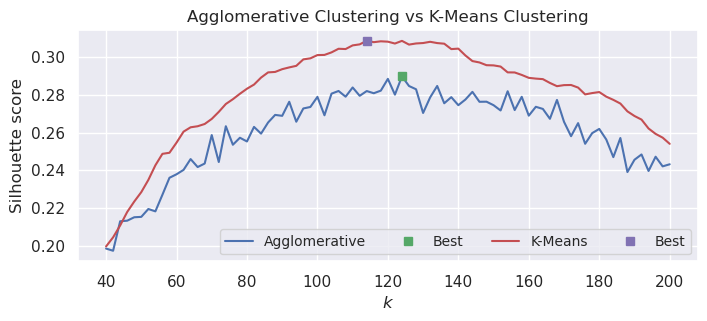

In [ ]:
from sklearn.cluster import AgglomerativeClustering

aggl_ward_per_k = []
for k in k_range:
    aggl_ward_per_k.append(AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X_train_pca))

ward_scores = [silhouette_score(X_train_pca, model.labels_) for model in aggl_ward_per_k]

plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots(1,1)
plot_score(ax, k_range, silhouette_scores, "Agglomerative Clustering vs K-Means Clustering")
plot_score(ax, k_range, ward_scores, "Agglomerative Clustering vs K-Means Clustering")
ax.legend(["Agglomerative", "Best" , "K-Means", "Best"], ncol=4, loc='lower right')
plt.show()

In general terms for this dataset, agglomerative clustering shows consistently better results than k-means as shown by their silhouette scores. The models share similar optimal values of $K$.

## Convolutional Neural Network

In order to improve performance over clustering methods, a convolutional neural network is proposed. 

Since unlike clustering algorithms which are unsupervised, the convolutional network will be trained with supervised training. The dataset is now partitioned into a training and validation set in addition to the test set. The images are also reshaped into the proper dimension that Keras requires.

In [ ]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40)
trainval_idx, test_idx = next(strat_split.split(data['images'], data['target']))
X_trainval = data['images'][trainval_idx]
y_trainval = data['target'][trainval_idx]
X_test = data['images'][test_idx]
y_test = data['target'][test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80)
train_idx, valid_idx = next(strat_split.split(X_trainval, y_trainval))
X_train = X_trainval[train_idx]
y_train = y_trainval[train_idx]
X_valid = X_trainval[valid_idx]
y_valid = y_trainval[valid_idx]

X_train = np.array([x.reshape(64,64,1) for x in X_train])
X_valid = np.array([x.reshape(64,64,1) for x in X_valid])
X_test  = np.array([x.reshape(64,64,1) for x in X_test])

### Feature Augumentation

Supervised training typically requires a larger dataset than the one we have, a common workaround for supervised training on small datasets is using data augumentation to create a large dataset from limited samples as follows.

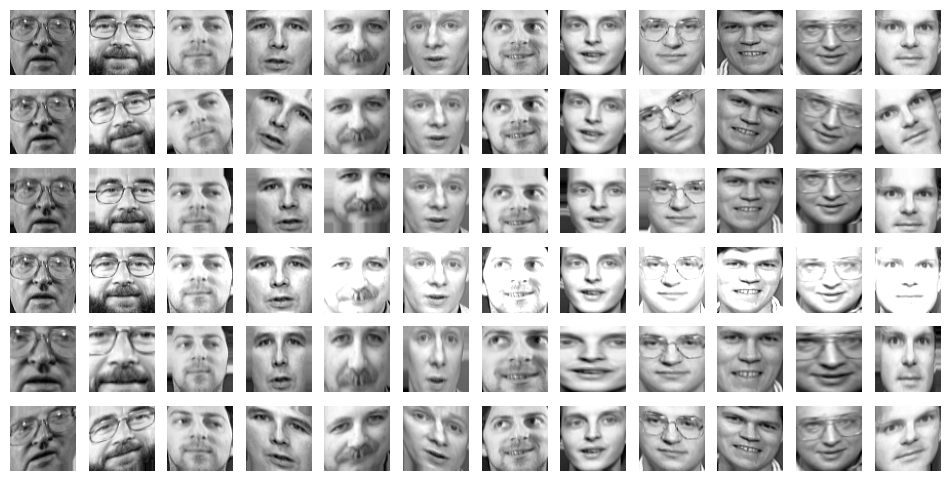

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
N = 12
plt.rcParams["figure.figsize"] = (N,6)
fig, axs = plt.subplots(6,N)
for ax in axs:
    for a in ax:
        a.axis("off")
datagen = ImageDataGenerator(horizontal_flip=True)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=N, shuffle=False):
    for j in range(N):
        axs[0,j].imshow(X_batch[j].reshape(64,64), cmap=plt.get_cmap("gray"))
    break
datagen = ImageDataGenerator(rotation_range=30)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=N, shuffle=False):
    for j in range(N):
        axs[1,j].imshow(X_batch[j].reshape(64,64), cmap=plt.get_cmap("gray"))
    break
datagen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=N, shuffle=False):
    for j in range(N):
        axs[2,j].imshow(X_batch[j].reshape(64,64), cmap=plt.get_cmap("gray"))
    break
datagen = ImageDataGenerator(brightness_range=[1,1.8])
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=N, shuffle=False):
    for j in range(N):
        axs[3,j].imshow(X_batch[j].reshape(64,64), cmap=plt.get_cmap("gray"))
    break
datagen = ImageDataGenerator(zoom_range=[0.6,1.2])
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=N, shuffle=False):
    for j in range(N):
        axs[4,j].imshow(X_batch[j].reshape(64,64), cmap=plt.get_cmap("gray"))
    break
datagen = ImageDataGenerator(shear_range=20)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=N, shuffle=False):
    for j in range(N):
        axs[5,j].imshow(X_batch[j].reshape(64,64), cmap=plt.get_cmap("gray"))
    break

Each row shows examples of the various random transformations that Keras can use to augument image data
- Randomly flip the image horizontally or vertically
- Randomly rotate the image
- Randomly shift the image horizontally or vertically
- Randomly increase or decrease the brightness of the image
- Randomly zoom the image in or out
- Randomly shear the image to the left or right

All of these functions will be randomly applied to the dataset to augument the testing and validation data

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             shear_range=10,
                             rotation_range=15, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             brightness_range=[0.8,1.2], 
                             zoom_range=[0.9,1.1])

### Design of the network

Proper design of a convolutional neural network is quite complicated, and is what makes the difference between an excellent neural network and one that fails to train at all. The many hyperparameters to choose from include the number of layers, the amount of channels in each layer, the size of the filters, and the activation functions to be used. 

A good general principle is to begin with a low number of channels on the first layer to capture high level features, and increase the number of channels in each subsequent layer to distinguish increasingly precise features as the input propagates through the networks.

After much testing, following three convolutional layer architecture has shown to have consistently good results.

In [ ]:
from random import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

model=Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(64,64,1)))
model.add(MaxPooling2D((2,2),strides=2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2),strides=2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2),strides=2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(40, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

2022-09-29 16:33:14.079882: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 16:33:14.104331: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2804000000 Hz
2022-09-29 16:33:14.104697: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d1848f4dd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-29 16:33:14.104710: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-29 16:33:14.105824: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best perf

### Training the network

Hyperparameters are also present when training the network, in this case the number of epochs and the batch size of the training and validation sets per epoch. A corect choice of these hyperparameters results in a good balance between speed of training and accuracy.

In [ ]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

history = model.fit(
  datagen.flow(X_train, to_categorical(y_train), batch_size=1400),
  epochs=250,
  validation_data=datagen.flow(X_valid, to_categorical(y_valid), batch_size=400),
  verbose=0
)

Keras allows us to easily observe the training history of the convolutional neural network across its epochs in terms of the Loss and Accuracy metrics.

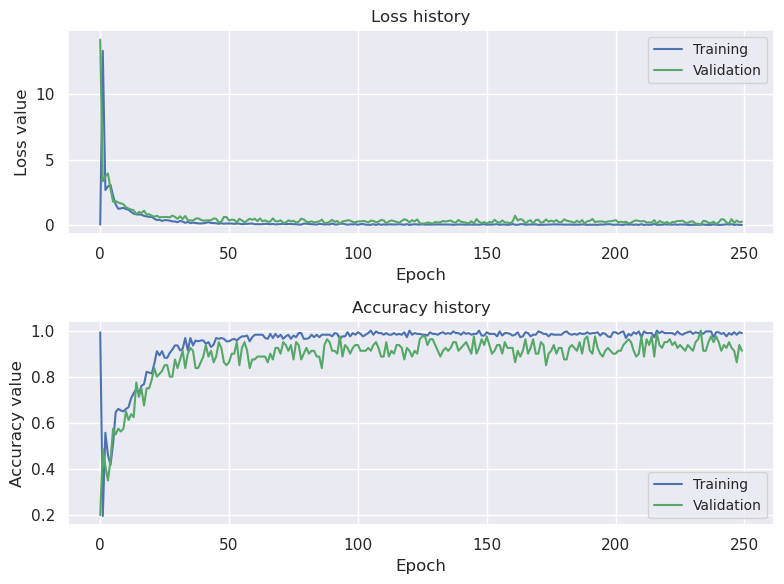

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
fig, axs = plt.subplots(2,1)
# Visualize history
# Plot history: Loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss history')
axs[0].set_ylabel('Loss value')
axs[0].set_xlabel('Epoch')
axs[0].legend(["Training", "Validation"])

# Plot history: Accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy history')
axs[1].set_ylabel('Accuracy value')
axs[1].set_xlabel('Epoch')
axs[1].legend(["Training", "Validation"])

plt.tight_layout()

Finally, we apply the trained network to the augumented dataset to assess its performance against unseen data.

In [ ]:
# Generate generalization metrics
score = model.evaluate(datagen.flow(X_test, to_categorical(y_test), batch_size=400))

1/1 [==============================] - 0s 50ms/step - loss: 0.1023 - accuracy: 0.9500
